<h3>Application and comparason of different machiene learning algorithms on cartography clasification problem</h3>

<h3>1. Setup figures properties</h3>

In [1]:
# setup plots
import seaborn as sns

sns.set_theme()
custom_rc = {
        "axes.axisbelow": True,
        "axes.edgecolor": "black",
        "axes.facecolor": "white",
        "axes.grid": False,
        "axes.labelcolor": "black",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "black",
        "xtick.bottom": True,
        "xtick.color": "black",
        "xtick.direction": "out",
        "xtick.top": False,
        "xtick.left": True,
        "ytick.color": "black",
        "ytick.direction": "out",
        "ytick.left": True,
        "ytick.right": False,
        "legend.facecolor": "white",
        #"grid.color": "black",
        #"grid.linestyle": "--",
}
sns.set_style(style="ticks", rc=custom_rc)

sns.set_context(
    "notebook",
    rc={
        "font.size": 16,
        "axes.titlesize": 22,  # numbers
        "axes.labelsize": 25,  # text
        "legend.fontsize": 20,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,    # fontsize of the tick labels
        #"grid.linewidth": 0.5,
    },
)
sns.set_palette("Set2")

<h3>2. Read in and process data</h3>

In [2]:
# packages
import os
from osgeo import gdal, ogr, gdal_array 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [3]:
# source dirs
folder_src = r"./id1"
folder_results = r"./results"
# training testing data
training = os.path.join(folder_src,'training_data.shp')
testing = os.path.join(folder_src,'testing_data.shp')
n_cores = -1
s2_stack = os.path.join(folder_src,'S2A_L2A_T32UPU_id1.tif')

In [4]:
# load image data
#In this script we are Using gdal.open() instead of rio.open()
img_ds = gdal.Open(s2_stack, gdal.GA_ReadOnly)
ROW,COL,N_BAND = img_ds.RasterYSize, img_ds.RasterXSize,img_ds.RasterCount

img = np.zeros((ROW, COL, N_BAND),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

print("Raster format is:", gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
print("Raster number of rows: {}".format(ROW))
print("Raster number of columns: {}".format(COL))
print("Raster number of bands: {}".format(N_BAND))


Raster format is: <class 'numpy.uint16'>
Raster number of rows: 87
Raster number of columns: 127
Raster number of bands: 4


In [5]:
# reshape the data to fit the clasifiers model input 
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :int(img.shape[2])].reshape(new_shape)
img_as_array = np.nan_to_num(img_as_array)
print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

Reshaped from (87, 127, 4) to (11049, 4)


In [6]:
def getRoi(file):
    # what is the numerical attribute of your classes in the shapefile?
    attribute = 'id'
    # load training data and show all shapefile attributes
    shape_dataset = ogr.Open(file)
    shape_layer = shape_dataset.GetLayer()

    # extract the names of all attributes (fieldnames) in the shape file
    attributes = [] # empty list where the attributes will be saved
    ldefn = shape_layer.GetLayerDefn() # encapsulates the attribute schema of the features of the layer
    for n in range(ldefn.GetFieldCount()):
        fdefn = ldefn.GetFieldDefn(n)
        attributes.append(fdefn.name)
    
    # copy the structure of your Sentinel2 image to pass this information to the new rasterized polygons
    att_ = 'ATTRIBUTE='+attribute
    band = 1
    # constructing merged raster image
    mem_drv = gdal.GetDriverByName('MEM')
    mem_raster = mem_drv.Create('',COL,ROW,band,gdal.GDT_UInt16)
    mem_raster.SetProjection(img_ds.GetProjection())
    mem_raster.SetGeoTransform(img_ds.GetGeoTransform())

    # rasterize your polygons
    mem_band = mem_raster.GetRasterBand(band)
    mem_band.Fill(0)
    mem_band.SetNoDataValue(0)
    err = gdal.RasterizeLayer(mem_raster, [band], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
    assert err == gdal.CE_None
    roi = mem_raster.ReadAsArray()
    return roi, attributes
    

In [7]:
# loading rasta training/ testing to memory 
roi_training, attributes = getRoi(training)
roi_testing, _ = getRoi(testing)

print('Available attributes in the shapefile are: {}'.format(attributes))

Available attributes in the shapefile are: ['id', 'water', 'tree', 'road', 'urban', 'field']


In [8]:
# get training and testing datasets
def getTrainTestSet(X,train,test):
    X_train = np.nan_to_num(X[train > 0, :])
    y_train = np.nan_to_num(train[train > 0])
    
    X_test = np.nan_to_num(X[test > 0, :])
    y_test = np.nan_to_num(test[test > 0])
    return X_train,y_train,X_test,y_test

In [9]:
X_train,y_train,X_test,y_test = getTrainTestSet(img,roi_training,roi_testing)
print("X_train samples:", X_train.shape)
print("y_train samples:", y_train.shape)
print("X_test samples:", X_test.shape)
print("y_test samples:", y_test.shape)

X_train samples: (684, 4)
y_train samples: (684,)
X_test samples: (1806, 4)
y_test samples: (1806,)


In [10]:
img[:,:,0:-1]/np.max(img[:,:,0:-1])

array([[[0.06302054, 0.07606885, 0.02720711],
        [0.05968906, 0.07717934, 0.02859522],
        [0.06496391, 0.07745697, 0.02554137],
        ...,
        [0.07828984, 0.15963354, 0.09827873],
        [0.05857857, 0.11854525, 0.07357024],
        [0.03387007, 0.08911716, 0.04553026]],

       [[0.06107718, 0.07606885, 0.02498612],
        [0.06385341, 0.07995558, 0.02637424],
        [0.06746252, 0.08106607, 0.02415325],
        ...,
        [0.06163243, 0.14242088, 0.08273182],
        [0.04469739, 0.08856191, 0.06163243],
        [0.04330927, 0.09716824, 0.04969461]],

       [[0.05913381, 0.07606885, 0.02443087],
        [0.06635203, 0.08162132, 0.02387562],
        [0.07051638, 0.08217657, 0.02248751],
        ...,
        [0.05052748, 0.11521377, 0.0719045 ],
        [0.05136036, 0.08300944, 0.05691283],
        [0.04747363, 0.10299833, 0.05080511]],

       ...,

       [[0.27873404, 0.37090505, 0.40421988],
        [0.35924486, 0.43198223, 0.50583009],
        [0.27456968, 0

In [11]:
A = img[:,:,3]/np.max(img[:,:,3])

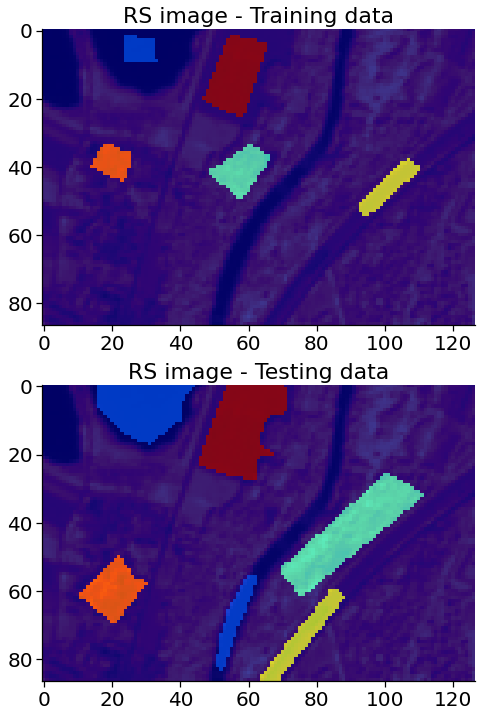

In [12]:
# plot training and testing data
fig, ax = plt.subplots(2,1, figsize=(15,12))
ax[0].imshow(A)
ax[0].imshow(roi_training, cmap='jet', alpha=0.75)
ax[0].set_title('RS image - Training data')
ax[1].imshow(A)
ax[1].imshow(roi_testing, cmap='jet', alpha=0.75)
ax[1].set_title('RS image - Testing data')
fig.savefig(
    "figures/training_testing_data.pdf",
    bbox_inches="tight",
    format="pdf",
)

<h3>3. Classification</h3>


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

- Labels for the classification: 1: water, 2: tree, 3: road, 4: urban, 5: field
- Below we define some useful functions for further use 

In [14]:
colors = sns.color_palette("Set2")

In [15]:
classes = attributes[1:]
label_train_index = [1,2,3,4,5]
label_colors_train = ["lightblue",colors[4],colors[-1],colors[-2],colors[-3]]

In [16]:
def plot_predictions(pred,title):
    # assing colors to each class. The order of the colors depends on the order of the landclasses
    custom_cmap = ListedColormap(label_colors_train)
    # for example, here water = "lightseagreen"

    # plot your classification
    fig,ax = plt.subplots(figsize=(10,10))
    ax.set_title(title, fontsize = 25) # use '\n' to start a new line
    plot_md =ax.imshow(pred, cmap=custom_cmap) # indicate which file will be plottd, add colors
    # set parameters for colorbar
    insax = inset_axes(ax, width="40%", height="5%", loc="lower right", bbox_to_anchor=(-0.025,0.05,1,1),bbox_transform=ax.transAxes)
    cbar_md = fig.colorbar(plot_md, cax=insax, shrink=0.6, orientation='horizontal') 
    cbar_md.set_ticks(label_train_index)
    cbar_md.set_ticklabels(classes)
    cbar_md.ax.tick_params(labelsize=20) # adapt font size of ticks
    # show your plot

    plt.savefig("figures/{title}.pdf".format(title=title),
        bbox_inches="tight",
        format="pdf",)
    plt.show()

In [17]:
# writing the tiff image file
# this function does not seem to work properly for some reason
def write_img_to_file(file_name, pred):
    # define where the image will be saved
    fpath=os.path.join(folder_results,file_name)
    cols = img.shape[1]
    rows = img.shape[0]

    # define structure of your output file
    driver = gdal.GetDriverByName("GTiff")
    outdata = driver.Create(fpath, COL, ROW, 1, gdal.GDT_UInt16)
    outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
    outdata.SetProjection(img_ds.GetProjection())##sets same projection as input

    # specify which image you want to save
    outdata.GetRasterBand(1).WriteArray(pred)

    #saves to disk!!
    outdata.FlushCache() 

    print('Image saved to: {}'.format(fpath))
    # optionaly save to file fig.savefig(os.path.join(folder_results, "classi_rf_250.png"), bbox_inches='tight')

<h3>3.1 Classification - KNN - K-Nearest Neighbours</h3>

<h5>The minimum distance classifier is used to classify unknown image data to classes which minimize the distance between the image data and the class in multi-feature space. The distance is defined as an index of similarity so that the minimum distance is identical to the maximum similarity.</h5>

In [18]:
knn_model = KNeighborsClassifier(n_neighbors=3, n_jobs=n_cores)
import time
start = time.time()
knn_model.fit(X_train, y_train)
end = time.time()
print("Training KNN in: ", str(end-start))

Training KNN in:  0.002834320068359375


In [19]:
# Predicting the rest of the image
# Use the raster in the format assigned on question nr.6
knn_prediction = knn_model.predict(img_as_array)
knn_prediction = knn_prediction.reshape(img[:, :, 0].shape)

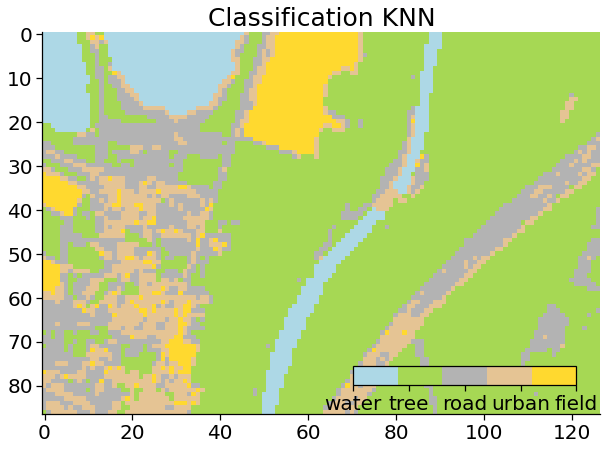

In [20]:
title = 'Classification KNN'
plot_predictions(knn_prediction, title)

In [21]:
name = 'md_classi.tif'
write_img_to_file(name, knn_prediction)

Image saved to: ./results/md_classi.tif


<h3>3.2 Classification - RF - Random Forest</h3>

<h4>Random Forest</h4>
<h5>A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting</h5>

In [22]:
from joblib import dump, load
import os, time
model_name = "rf_model.joblib"
rf_model = None
# define a number of trees that should be used (default = 100)
est = 500
if os.path.exists(model_name):
    rf_model = load(model_name)
else:
    # run the RF algorithm
    rf_model = RandomForestClassifier(n_estimators=est, oob_score=True, n_jobs=n_cores, bootstrap = True)
    start = time.time()
    rf_model.fit(X_train, y_train)
    end = time.time()
    print("Training RF in: ", str(end-start))
    dump(rf_model, model_name) 

In [23]:
# Now predict for each pixel
rf_prediction = rf_model.predict(img_as_array)
print('Shape prediction {}'.format(rf_prediction.shape))

rf_prediction = rf_prediction.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(rf_prediction.shape))

Shape prediction (11049,)
Reshaped back to (87, 127)


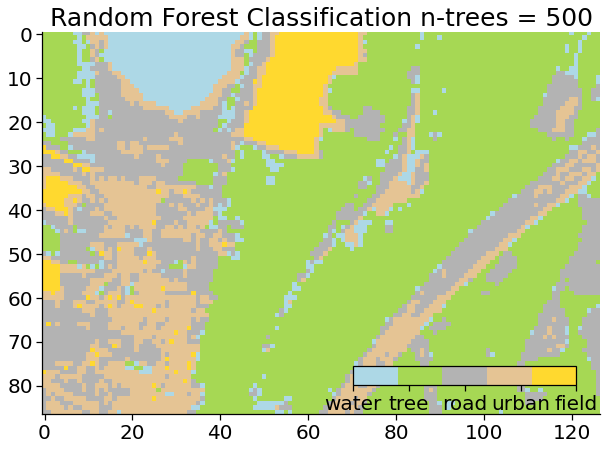

In [24]:
# plot results
title = 'Random Forest Classification n-trees = {}'.format(est)
plot_predictions(rf_prediction, title)

In [25]:
name = 'rf_nt250.tif'
write_img_to_file(name,rf_prediction)

Image saved to: ./results/rf_nt250.tif


<h3>3.3 Classification - SVM Clasification</h3>

In [27]:
from joblib import dump, load
import os
model_name = "svm_model.joblib"
svc_model = None
if os.path.exists(model_name):
    svc_model = load(model_name)
else:
    # make model
    from sklearn.svm import SVC
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn.ensemble import BaggingClassifier
    import time
    n_estimators = 10
    svc_model = OneVsRestClassifier(BaggingClassifier(SVC(kernel='poly',degree=4, gamma='auto', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=n_cores),n_jobs=n_cores)
    start = time.time()
    svc_model.fit(X_train, y_train)
    end = time.time()
    print("Training svm took: ",str(end-start))
    dump(svc_model, model_name) 

In [28]:
svc_predict = svc_model.predict(img_as_array)
svc_predict = svc_predict.reshape(img[:, :, 0].shape)

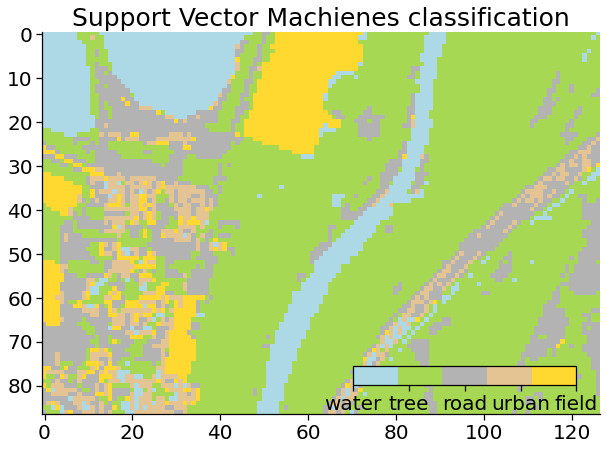

In [29]:

title = 'Support Vector Machienes classification'
plot_predictions(svc_predict, title)

<h3>4. Accuracy</h3>

In [30]:
import sklearn.metrics
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import matplotlib.pyplot as plt
import time

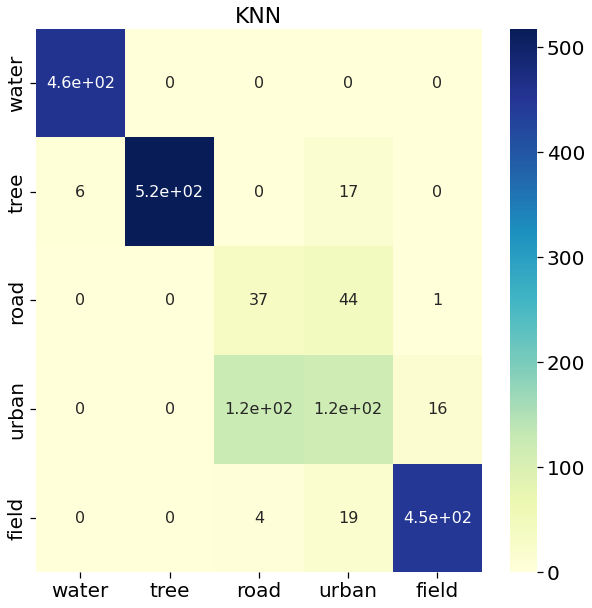

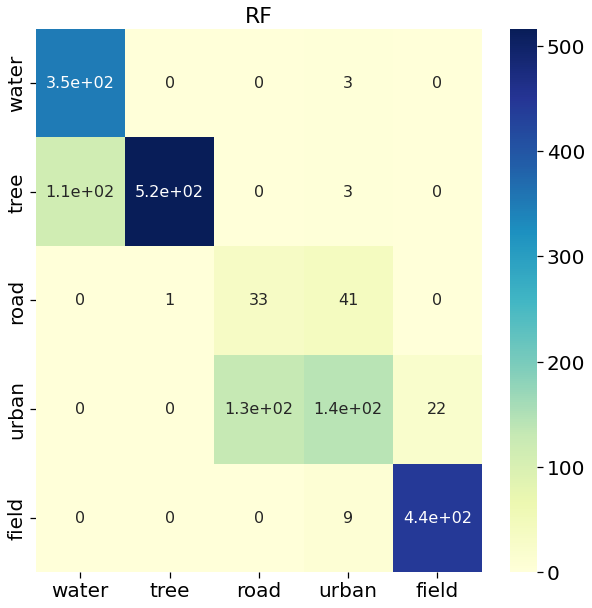

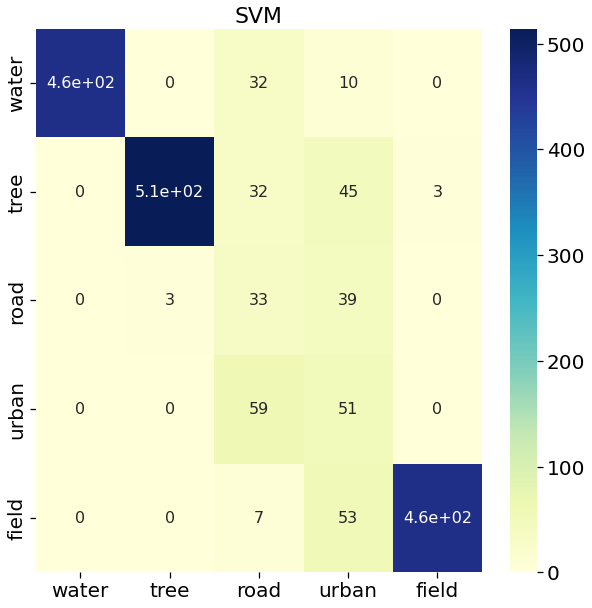

In [31]:
# KNN
start = time.time()
pred__test_knn = knn_model.predict(X_test)
end = time.time()
pred__test_knn_time = end-start

target_test_knn = y_test
cm_knn = sklearn.metrics.confusion_matrix(pred__test_knn, target_test_knn)
ck_knn = cohen_kappa_score(pred__test_knn, target_test_knn)

# RF
start = time.time()
pred__test_rf = rf_model.predict(X_test)
end = time.time()
pred__test_rf_time = end-start

target_test_rf = y_test
cm_rf = sklearn.metrics.confusion_matrix(pred__test_rf, target_test_rf)
ck_rf = cohen_kappa_score(pred__test_rf, target_test_rf)

# SVM
start = time.time()
pred__test_svm = svc_model.predict(X_test)
end = time.time()
pred__test_svm_time = end-start

target_test_svm = y_test
cm_svm = sklearn.metrics.confusion_matrix(pred__test_svm, target_test_svm)
ck_svm = cohen_kappa_score(pred__test_svm, target_test_svm)

cm = [cm_knn,cm_rf,cm_svm]
ck = [ck_knn,ck_rf,ck_svm]
label = ["KNN","RF","SVM"]
for i in range(0,len(cm)):
    df_cm = pd.DataFrame(cm[i], classes,
                      columns = classes)
    plt.figure(figsize = (10,10));
    plt.title(label[i])
    sns.heatmap(df_cm,cmap="YlGnBu",annot=True,vmin=0)
    plt.savefig("figures/cm_{}.pdf".format(label[i]),
    bbox_inches="tight",
    format="pdf",)


Accuracy score for KNN
0.8732004429678848
Accuracy score for RF
0.8217054263565892
Accuracy score for SVM
0.8433001107419712


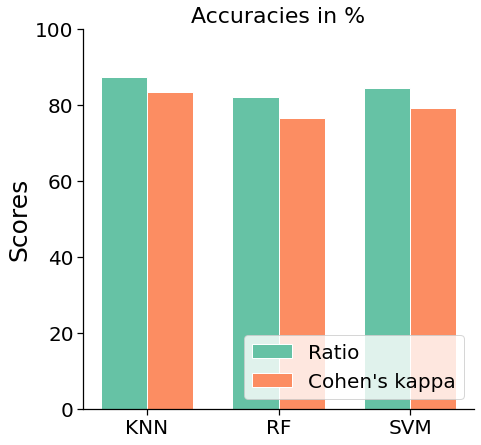

In [32]:
from sklearn.metrics import accuracy_score

label = ["KNN","RF","SVM"]
pred = [pred__test_knn,pred__test_rf,pred__test_svm]
mix = dict(zip(label,pred))
acc = []
for l in mix:
    print("Accuracy score for {}".format(l))
    ac = accuracy_score(y_test,mix[l])
    print(ac)
    acc.append(ac)

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, [i*100 for i in acc], width)
rects2 = ax.bar(ind+width, [i*100 for i in ck], width)
ax.set_ylabel('Scores')
ax.set_title("Accuracies in %")
ax.set_ylim([0, 100])
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( ('KNN', 'RF', 'SVM') )
ax.legend((rects1[0], rects2[0]), ('Ratio', "Cohen's kappa"), loc='lower right')
plt.savefig("figures/accuracy.pdf",
    bbox_inches="tight",
    format="pdf",)

<h3>5. Performance/Runtime</h3>

In [33]:
pred_test_time = [pred__test_knn_time, pred__test_rf_time, pred__test_svm_time]
# results from training
train_time = [0.0021483898162841797,2.1619153022766113,46.528648853302]

In [34]:
train_time

[0.0021483898162841797, 2.1619153022766113, 46.528648853302]

In [35]:
pred_test_time

[0.18580269813537598, 0.3080461025238037, 0.17182374000549316]

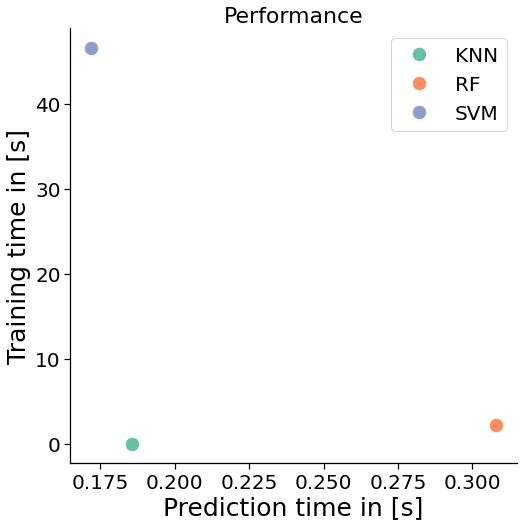

In [36]:
label = ["KNN","RF","SVM"]

plt.figure(figsize=(8,8))
plt.title("Performance")
plt.plot(pred_test_time[0],train_time[0],'.',markersize=25, label="KNN")
plt.plot(pred_test_time[1],train_time[1],'.',markersize=25, label="RF")
plt.plot(pred_test_time[2],train_time[2],'.',markersize=25, label="SVM")
plt.xlabel("Prediction time in [s]")
plt.ylabel("Training time in [s]")
plt.legend(loc="best")
plt.savefig("figures/performance.pdf",
    bbox_inches="tight",
    format="pdf",)